# MonteCarlo Based Basic Health Dataset generation.

Since there are no public available datasets, we had to create our own dtaaset.
We used ESP32 and MAX30105 for the generation of raw data which resembles the private health data for the virus outbreak.  

The dataset is exclusively used to provide some input for the Federated Learning approach in the next notebook.  

# Approach

A **graph of people** is created using the data generated thru the IoT devices. Each **person has some attributes** which he would have to track in real life by hand or an app or any other way of analysis.

After **infecting a random person** with a virus the edges of the graph are used to **simulate a probability based spreading** of the virus. 

For each simulated day the **attributes of each person are being updated based on their status of infection**.

This health status of each person is used as toy dataset.


# 1. Import Libraries

In [1]:
# To do linear algebra
import numpy as np

# To store data
import pandas as pd

# To create networks
import networkx as nx

# To create plots
import matplotlib.pyplot as plt

# 2. Setup Variables, Functions And Classes

In [7]:
########## Variables ##########
# Choose to create a trainingset or a testingset
trainingset = True

# Set global infection rate
infection_rate = 0.25

# Set global healing rate
healing_rate = 0.1

# Number of days to simulate
n_days = 50

# Number of nodes in the graph
n = 10000

# Number of edges in the graph
m = 25000


########## Functions ##########
def getTemperature(person):
    '''
    float - temperature value (track by hand or smartphone)
    Infected people have a higher temperature
    Sample a gaussian distribution with higher mean for infected people
    '''
    
    if person.infected:
        # Mean temperature of infected people 38
        return np.random.normal(38, 0.5)
    else:
        # Mean temperature of healthy people 37
        return np.random.normal(37, 0.5)


def getDistance(person):
    '''
    float - movement distance (track with GPS)
    Infected people move less during the day
    Sample a gaussian distribution with lower mean for infected people
    '''
    
    if person.infected:
        # Mean movement distance of infected people 1000
        return np.random.normal(1000, 200)
    else:
        # Mean movement distance of healthy people 2000
        return np.random.normal(2000, 500)


def getCough(person):
    '''
    bool - coughing during the day (track by hand or smartphone)
    Infected people cough more often
    Sample a gaussian distribution with higher mean for infected people
    '''
    
    if person.infected:
        # Infected people probably cough
        return np.random.choice([True, False], p=[0.75, 0.25])
    else:
        # Healthy people probably do not cough
        return np.random.choice([True, False], p=[0.25, 0.75])



########## Classes ##########
# Define class with attributes for the nodes/people in society
class Person:
    
    def __init__(self):
        # Is the person infected right now
        self.infected = False
    
        # Has the person had the infection and is now immune
        self.immune = False
        
        # Get a random temperature 
        self.temperature = getTemperature(self)
        
        # Get a random walking distance
        self.distance = getDistance(self)
        
        # Get random coughing symptoms
        self.cough = getCough(self)

# 3. Create A Random Graph With Patient Zero

In [3]:
# Create the graph
graph = nx.dense_gnm_random_graph(n=n, m=m)


# Create a person for each node
people = {i:Person() for i in range(n)}

# Add the person to its node as attribute
nx.set_node_attributes(graph, people, 'person')


# Get a random patient zero
patient_zero = np.random.choice(graph.nodes)

# Infect patient zero
graph.nodes[patient_zero]['person'].infected = True

# 4. Simulate The Virus Outbreak

In [4]:
# Variable to store the health data of the people
data = []


# Iterate over all simulated days
for day in range(n_days):

    ########## Get Health Status ##########
    # Iterate over all nodes to store their current health status
    for node, person in nx.get_node_attributes(graph, 'person').items():

        # Get the current health status
        infected = person.infected
        immune = person.immune
        temperature = person.temperature
        distance = person.distance
        cough = person.cough

        # Store the current health status
        data.append([day, node, infected, immune, temperature, distance, cough])


    ########## Simulate New Day ##########
    # Iterate over all nodes to simulate a new day and update their health status
    for node, person in nx.get_node_attributes(graph, 'person').items():
        
        # Update health status
        person.temperature = getTemperature(person)
        person.distance = getDistance(person)
        person.cough = getCough(person)

        
        # Check if the node is infected:
        if person.infected:

            # Iterate over all neighbors of the node
            for neighbor in graph.neighbors(node):

                # Continue if the person is immune
                if graph.nodes[neighbor]['person'].immune:
                    continue

                # Otherwise simulate random infection
                if np.random.random() < infection_rate:
                    graph.nodes[neighbor]['person'].infected = True
            
            # Simulate healing process
            if np.random.random() < healing_rate:
                person.infected = False
                person.immune = True

# 5. Inspect The Outbreak

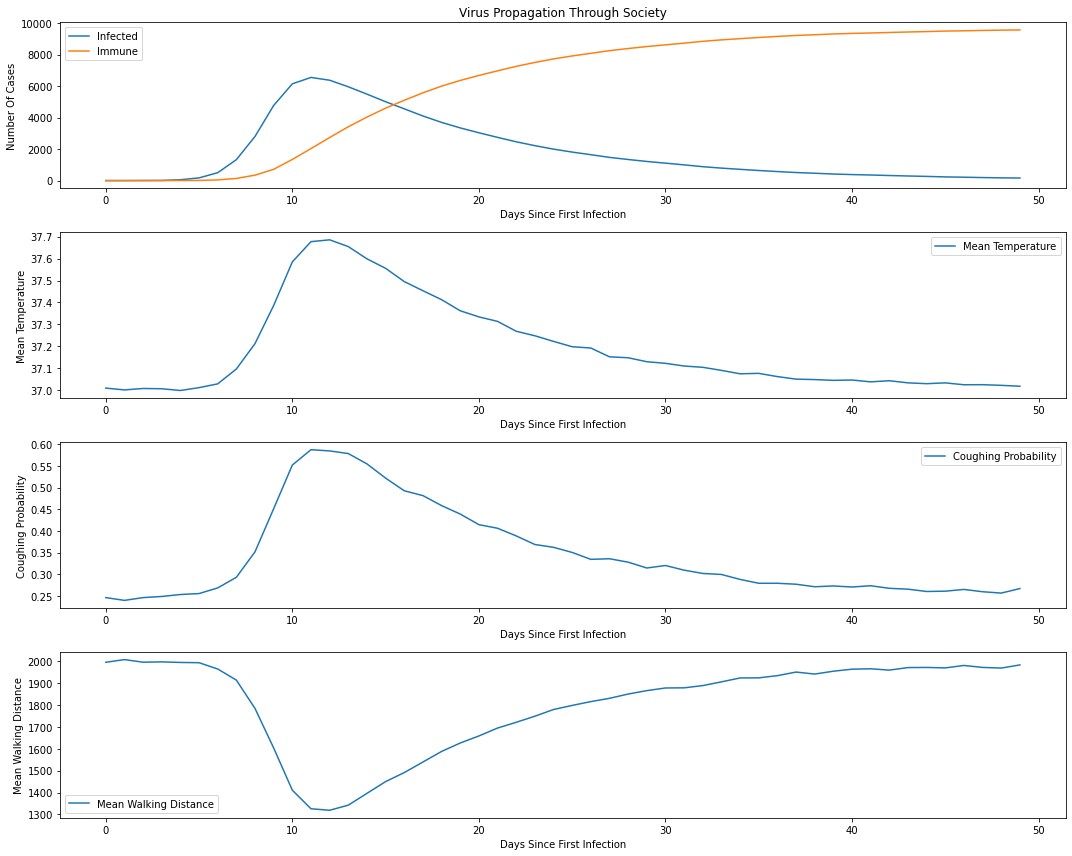

In [8]:
# Store the data for better inspection
df = pd.DataFrame(data, columns=['Day', 'Node', 'Infected','Immune', 'Temperature', 'Distance', 'Cough'])

# Store the data as csv-file
df.to_csv('data/{}_Simulated_Virus_Outbreak.csv'.format('Trainingset' if trainingset else 'Testingset'), index=False)

# Create subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,12))

# Create first plot
df.groupby('Day')[['Infected', 'Immune']].sum().plot(title='Virus Propagation Through Society', ax=ax1)
ax1.set_xlabel('Days Since First Infection')
ax1.set_ylabel('Number Of Cases')

# Create second plot
df.groupby('Day')['Temperature'].mean().plot(ax=ax2)
ax2.set_xlabel('Days Since First Infection')
ax2.set_ylabel('Mean Temperature')
ax2.legend(['Mean Temperature'])

# Create third plot
df.groupby('Day')['Cough'].mean().plot(ax=ax3)
ax3.set_xlabel('Days Since First Infection')
ax3.set_ylabel('Coughing Probability')
ax3.legend(['Coughing Probability'])

# Create fourth plot
df.groupby('Day')['Distance'].mean().plot(ax=ax4)
ax4.set_xlabel('Days Since First Infection')
ax4.set_ylabel('Mean Walking Distance')
ax4.legend(['Mean Walking Distance'])

plt.tight_layout()
plt.savefig('build/{}_Virus_Outbreak_Inspection.png'.format('Trainingset' if trainingset else 'Testingset'))
plt.show()

In [19]:
df.sample(5)

,Day,Node,Infected,Immune,Temperature,Distance,Cough
368098,36,8098,False,False,36.677776,2884.361748,False
365850,36,5850,False,True,37.807804,2177.498678,True
40732,4,732,False,False,37.086651,1479.514389,False
290545,29,545,False,True,37.333927,1476.225723,False
266654,26,6654,False,True,36.748246,2083.086567,False
